# Build Model

In [ ]:
from functools import partial
import torch.nn as nn

In [2]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)   

In [3]:
def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [5]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels


def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))


In [6]:
class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [7]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

In [8]:
class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [9]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation='relu', block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            Conv2dAuto(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, bias=False),
            # nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation_func(activation),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,*args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [10]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [11]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
def resnet18(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[2, 2, 2, 2], *args, **kwargs)

def resnet34(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[3, 4, 6, 3], *args, **kwargs)

def resnet50(in_channels, n_classes, block=ResNetBottleNeckBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[3, 4, 6, 3], *args, **kwargs)

def resnet101(in_channels, n_classes, block=ResNetBottleNeckBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[3, 4, 23, 3], *args, **kwargs)

def resnet152(in_channels, n_classes, block=ResNetBottleNeckBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[3, 8, 36, 3], *args, **kwargs)


# Compare Models

In [2]:
from torchsummary import summary
import resnet

model = resnet.resnet18(3, 1000)
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dAuto-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
        Conv2dAuto-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
        Conv2dAuto-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
 ResNetBasicBlock-11           [-1, 64, 56, 56]               0
       Conv2dAuto-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [3]:
import torchvision.models as models

summary(models.resnet18(False).cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

/home/paperspace/Documents/Repos/ResNet-PyTorch/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/home/paperspace/Documents/Repos/ResNet-PyTorch/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Image Augmentation

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

Files already downloaded and verified


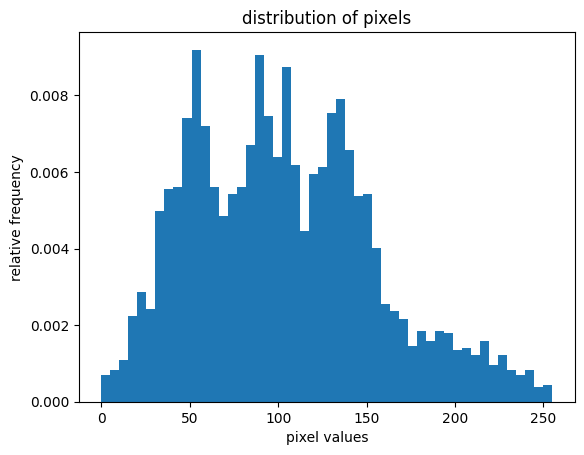

In [6]:
img = trainset[0][0]

plt.hist(np.array(img).ravel(), bins=50, density=True);
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testset, valset = random_split(testset,[8000,2000])

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Number of training images: ", len(trainset))

Files already downloaded and verified
Files already downloaded and verified
Number of training images:  50000


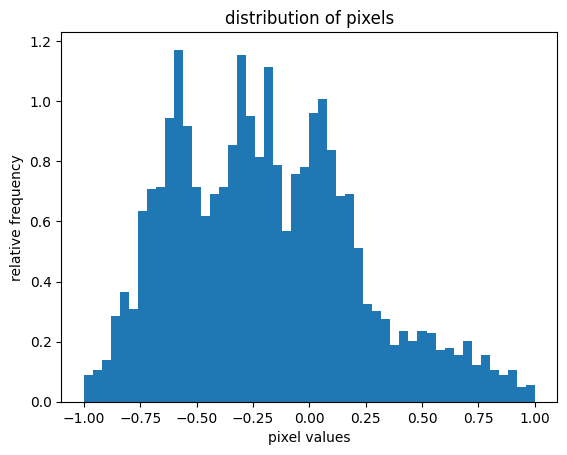

In [8]:
img_normalized = trainset[0][0]

plt.hist(np.array(img_normalized).ravel(), bins=50, density=True);
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

# Train Model

In [9]:
import torch.optim as optim
import torch.nn as nn

model = resnet.resnet50(3, 10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
# Assuming that we are on a CUDA machine, this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
model.to(device)

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2dAuto(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [13]:
epochs = []
train_losses = []
val_losses = []

ckpt_batch = 150

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    train_loss = 0
    model.train()
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        # print checkpoints every 100 batches or at the end of an epoch
        if i % ckpt_batch == ckpt_batch-1 or i==len(trainloader)-1:
            if i==len(trainloader)-1:
                print('Finished epoch: %d, loss: %.3f' % (epoch + 1, running_loss / (i % ckpt_batch + 1)))
            elif i % ckpt_batch == ckpt_batch-1:    
                print('epoch: %d, batch: %5d, loss: %.3f' % (epoch + 1, i + 1, running_loss / (i % ckpt_batch + 1)))
            train_loss += running_loss / (i % ckpt_batch + 1)
            running_loss = 0.0

    val_loss = 0.0
    model.eval()
    with torch.inference_mode():
        for i, data in enumerate(valloader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    epochs.append(epoch+1)
    train_losses.append(train_loss)
    val_losses.append(val_loss / len(valloader))


print('Finished Training')

epoch: 1, batch:   150, loss: 2.190
epoch: 1, batch:   300, loss: 1.979
epoch: 1, batch:   450, loss: 1.736
epoch: 1, batch:   600, loss: 1.650
epoch: 1, batch:   750, loss: 1.589
Finished epoch: 1, loss: 1.517
epoch: 2, batch:   150, loss: 1.489
epoch: 2, batch:   300, loss: 1.454
epoch: 2, batch:   450, loss: 1.437
epoch: 2, batch:   600, loss: 1.421
epoch: 2, batch:   750, loss: 1.409
Finished epoch: 2, loss: 1.358
epoch: 3, batch:   150, loss: 1.292
epoch: 3, batch:   300, loss: 1.229
epoch: 3, batch:   450, loss: 1.234
epoch: 3, batch:   600, loss: 1.236
epoch: 3, batch:   750, loss: 1.256
Finished epoch: 3, loss: 1.210
epoch: 4, batch:   150, loss: 1.078
epoch: 4, batch:   300, loss: 1.084
epoch: 4, batch:   450, loss: 1.064
epoch: 4, batch:   600, loss: 1.078
epoch: 4, batch:   750, loss: 1.065
Finished epoch: 4, loss: 1.095
epoch: 5, batch:   150, loss: 0.922
epoch: 5, batch:   300, loss: 0.956
epoch: 5, batch:   450, loss: 0.922
epoch: 5, batch:   600, loss: 0.927
epoch: 5, ba

### Save Model

In [14]:
model_path = './models'
os.makedirs(model_path, exist_ok = True) 
torch.save(model.state_dict(), os.path.join(model_path, 'resnet_cifar.pt'))

# Visualize Training Loss

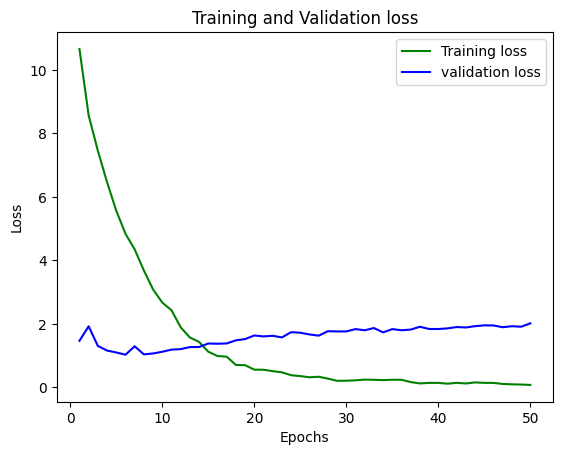

In [16]:
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load Trained Model

In [19]:
model = resnet.resnet50(3, 10)
model.load_state_dict(torch.load(os.path.join(model_path, 'resnet_cifar.pt')))

<All keys matched successfully>

In [36]:
## Pretrained Model
correct = 0
total = 0

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Since we're not training, we don't need to calculate the gradients for our outputs
model.to(device)
model.eval()

with torch.inference_mode():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)

        # calculate outputs by running images through the network
        outputs = model(inputs)

        # the class with the highest energy is what we choose as prediction
        _, predictions = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print('Accuracy of the network on the 10,000 test images: %.1f%%' % (
    100 * correct / total))

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f}%".format(classname,
                                                   accuracy))

Accuracy of the network on the 10,000 test images: 70.5%
Accuracy for class plane is: 76.6%
Accuracy for class car   is: 80.0%
Accuracy for class bird  is: 63.2%
Accuracy for class cat   is: 53.4%
Accuracy for class deer  is: 60.6%
Accuracy for class dog   is: 59.8%
Accuracy for class frog  is: 77.3%
Accuracy for class horse is: 72.4%
Accuracy for class ship  is: 85.2%
Accuracy for class truck is: 76.4%
